In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

#Yenny's dups file
json_file = "/Users/kimia/Desktop/Work5/duplicates_batch_2018-05-18.json"
df = pd.read_json(json_file, lines=True)
dfsub = json_normalize(df.submission)

#everything but payload ('twas messy, so I split it then merge)
metadf = dfsub[[ 'task_id', 'updated_at', 'user_id', 'created_at', 'id']]

dfsub = pd.DataFrame(dict(df.submission[0:])).T
dfpayloads = pd.DataFrame()

# I know this isn't efficient. But it helps split out the payloads (multiple per task_id). 
for i in range(dfsub.shape[0]):
    f = pd.DataFrame(dfsub.payload[i]).T
    f['id'] = dfsub.id[i]
    f['task_id'] = dfsub.task_id[i]
    f['user_id'] = dfsub.user_id[i]
    f['created_at'] = dfsub.created_at[i]
    f['updated_at'] = dfsub.updated_at[i]
    dfpayloads = pd.concat([dfpayloads, f])
    
dfpayloads = dfpayloads.reset_index()
dfpayloads = dfpayloads.rename(index=str, columns={"index": "payload"})
dfpayloads['count'] = 1 # this is to signify one input per user
#dfpayloads.to_csv('dfpayloads.csv')
dfpayloads['unique'] = (dfpayloads.task_id).apply(lambda x: str(x)) + (dfpayloads.payload).apply(lambda x: str(x))


In [107]:

taskusdf = pd.read_csv('/Users/kimia/Downloads/Karen.txt', sep=',')[3:]
#['Id', 'Email', 'First'  ,'Last' ,'Created' ,'Updated', 'Hire Date']
taskusdf = taskusdf[['Unnamed: 0', 'Unnamed: 3','Unnamed: 6' ]]

taskusdf['hire'] = pd.to_datetime(taskusdf['Unnamed: 6'],  errors = 'coerce')

taskusdf['today'] = pd.to_datetime('today')
taskusdf['totaltime'] = taskusdf['today'] -taskusdf['hire']
taskusdf["user_id"] = taskusdf["Unnamed: 0"]
taskusdf["user_id"] = taskusdf["user_id"].apply(lambda x: int(x))
taskusdf['timeclean'] = taskusdf['totaltime'].apply(lambda x: int(str(x)[0:3]))


In [108]:

df = dfpayloads 
df = pd.merge(df, taskusdf, on='user_id', how = 'left')


In [21]:
df['LastName'] = df['Unnamed: 3']
countdf = df.groupby(['user_id', 'LastName']).sum()['count'].sort_values().to_frame(name = 'count').reset_index()
del countdf['user_id']



LastName  count
0      Garciso    522
1      Pascual   4264
2       Ropeta   4771
3       Glomar   5559
4     Cruspero   5618
5     Prudente   5775
6       Abeabe   5952
7     Martinez   5967
8      Remulla   5997
9        Guieb   6027
10       Obina   6031
11      Calibo   6581
12   Penecilla   6862
13      Borres   6866
14  Sooksingha   7008
15          Te   7368
16      Lozano   7571
17  Camantigue   7582
18       Taala   7648
19    Dangalan   7655
20    Olivares   7671
21       Reyes   7686
22    Lagumbay   7729
23   Hernandez   7823
24       Camet   7869
25   Dela Rosa   8133

In [51]:
colors =  (2 * np.pi * np.random.rand(26))/10
len(colors)
len(countdf['count'])


26

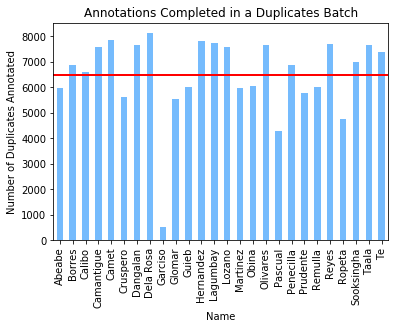

"plt.figure(figsize=(10,5))\nplt.hist(samps_normprop_pos_thinned,bins=100, alpha=0.4, label=u'MCMC distribution (Normal Proposal)', normed=True) \nplt.plot(xxx, f_1(xxx), 'r', label='actual f(x)')\nplt.legend()"

In [53]:

countdf.groupby('LastName').sum()['count'].plot(kind='bar', color = 'xkcd:sky blue')# xlabel="X-axis label", ylabel="y-axix label")
plt.title('Annotations Completed in a Duplicates Batch')
plt.xlabel('Agent')
plt.ylabel('Number of Duplicates Annotated')
plt.axhline(countdf['count'].mean(), color='red', linewidth=2)
plt.show()

"""plt.figure(figsize=(10,5))
plt.hist(samps_normprop_pos_thinned,bins=100, alpha=0.4, label=u'MCMC distribution (Normal Proposal)', normed=True) 
plt.plot(xxx, f_1(xxx), 'r', label='actual f(x)')
plt.legend()"""

0.00041715085962873574

In [86]:
## consensus

lowagreement = dfpayloads.groupby(['unique', 'annotation']).size().to_frame(name = 'count').reset_index()
fullagreement = lowagreement[lowagreement['count']>4] ## only 14 are consensus at 4 -- .0002%
lowagreement = lowagreement[lowagreement['count']<5]
print("no consensus:")
print((lowagreement.groupby(['unique']).count()).shape[0]/ (((dfpayloads.groupby(['unique']).count())).shape[0]))
print("consensus:")
print((fullagreement.groupby(['unique']).count()).shape[0]/ (((dfpayloads.groupby(['unique']).count())).shape[0]))


no consensus:
0.08938946992044337
consensus:
0.911564017758708


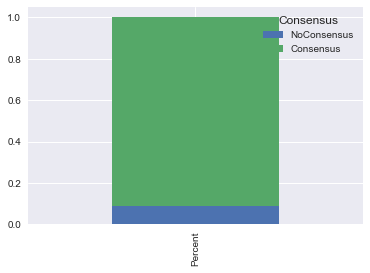

In [104]:
df = pd.DataFrame(columns=["Consensus","Percent", ], 
                  data=[["NoConsensus",0.08938946992044337,],
                   ["Consensus",0.911564017758708,]])
#palette=sns.color_palette("GnBu", 10) 
import seaborn as sns
sns.set()
df.set_index('Consensus').T.plot(kind='bar', stacked=True )



In [ ]:
## time
df['startdate'] = (df.created_at).apply(lambda x: str(pd.to_datetime(x))[0:11])
df['enddate'] = (df.updated_at).apply(lambda x: str(pd.to_datetime(x))[0:11])
np.sum(df['enddate'][0:5] != df['startdate'][0:5])
## everyone does it in one day

df['starttime'] = (df.created_at).apply(lambda x: (pd.to_datetime(str(x))))
df['endtime'] = (df.updated_at).apply(lambda x: (pd.to_datetime(str(x))))
df['totaltime'] = (df['endtime'] - df['starttime'] )

In [112]:
print("The median amount of time taken per task id is %s"% (df['totaltime'].median()) )
print("The 25th quantile of time taken per task id is %s"% (df['totaltime'].quantile(0.25)) )
print("The 75th quantile of time taken per task id is %s"% (df['totaltime'].quantile(0.75)) )
print("The max amount of time taken per task id is %s"% (df['totaltime'].max()) )
print("The min amount of time taken per task id is %s"% (df['totaltime'].min()) )

The median amount of time taken per task id is 0 days 00:02:17.946000
The 25th quantile of time taken per task id is 0 days 00:01:09.153000
The 75th quantile of time taken per task id is 0 days 00:05:29.377000
The max amount of time taken per task id is 11 days 01:29:57.246000
The min amount of time taken per task id is 0 days 00:00:14.460000


In [113]:
def consensus(df, column):
    lowagreement = df.groupby([ 'unique', str(column)]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] >4]
    perc5 = (len(agree5['unique'].unique())/len(lowagreement['unique'].unique()))
    accuracy = ({str(column):perc5})
    return accuracy  

In [114]:
consensus(df, 'annotation')

{'annotation': 0.911564017758708}

In [125]:
lowagreement = df.groupby([ 'unique', 'annotation']).size().to_frame(name = 'count').reset_index()


len(lowagreement[lowagreement['unique'].duplicated(keep=False)])/ len(lowagreement.unique)

0.16832598879277516

In [145]:
k  = pd.merge(lowagreement[lowagreement['unique'].duplicated(keep=False)], lowagreement, on = ['unique', 'annotation'], how = 'right')#)['unique'].unique())/len(lowagreement['unique'].unique())

In [169]:

consensus = k[6188:]
consensus['CONSENSUS'] = "CONSENSUS"
len(consensus)
consen = (pd.merge(consensus, dfpayloads, on = 'unique'))
len(consen), len(dfpayloads)

(153540, 168535)

In [423]:
from collections import Counter
#count number of times consensus
cnt = Counter()
for word in list(consen.user_id):
     cnt[word] += 1

d={}

for key, value in cnt.items():
    d[key] = value

#count number of times total
cnt = Counter()
for word in list(dfpayloads['user_id']):
     cnt[word] += 1

t={}

for key, value in cnt.items():
    t[key] = value
## merge the two
d = pd.DataFrame.from_dict(d, orient='index').reset_index()
t = pd.DataFrame.from_dict(t, orient='index').reset_index()
final = pd.merge(d,t , on = 'index')
final['%'] = final['0_x']/final['0_y']
final.sort_values(['%'], ascending = False)
final = final.rename(columns={"index": "user_id"})
final["user_id"] = final["user_id"].apply(lambda x: int(x))

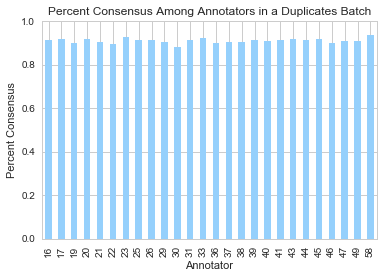

In [380]:
final
final.groupby('user_id').sum()['%'].plot(kind='bar', color = 'xkcd:light blue')# xlabel="X-axis label", ylabel="y-axix label")
plt.title('Percent Consensus Among Annotators in a Duplicates Batch')
plt.xlabel('Annotator')

plt.ylabel('Percent Consensus')
plt.yticks(np.arange(0, 1.20, step=0.2))

#plt.axhline(final['%'].median(), color='red', linewidth=2)
plt.show()

In [184]:
final

user_id   0_x   0_y         %
0        20  7108  7729  0.919653
1        40  5488  6027  0.910569
2        43  5095  5559  0.916532
3        37  6321  7008  0.901969
4        16  6276  6866  0.914069
5        49  6242  6862  0.909647
6        41  5433  5952  0.912802
7        29  6830  7571  0.902127
8        22  4260  4771  0.892895
9        38  5386  5967  0.902631
10       19   470   522  0.900383
11       21  7060  7823  0.902467
12       47  3869  4264  0.907364
13       39  6909  7582  0.911237
14       44  7201  7869  0.915110
15       46  6897  7671  0.899101
16       17  6053  6581  0.919769
17       33  7068  7648  0.924163
18       45  7008  7655  0.915480
19       31  5131  5618  0.913314
20       36  5435  6031  0.901177
21       25  6731  7368  0.913545
22       26  5275  5775  0.913420
23       58  7183  7686  0.934556
24       23  7531  8133  0.925981
25       30  5280  5997  0.880440

0.03921300000000005

In [223]:
#### divergence  = 6188
lowagreement = df.groupby([ 'unique', 'annotation']).size().to_frame(name = 'count').reset_index()


(lowagreement[lowagreement['unique'].duplicated(keep=False)])

k  = pd.merge(lowagreement[lowagreement['unique'].duplicated(keep=False)], lowagreement, on = ['unique', 'annotation'], how = 'right')#)['unique'].unique())/len(lowagreement['unique'].unique())
diverge = k[:6188]

In [225]:
#diverge['howmany23'] = (diverge.unique).apply(lambda x: str(x)) + (diverge.annotation).apply(lambda x: str(x))
cnt = Counter()
for word in list(diverge['unique']):
     cnt[word] += 1

diverge={}

for key, value in cnt.items():
    diverge[key] = value
diverge2 = pd.DataFrame.from_dict(diverge, orient='index').reset_index()

In [249]:
#2773*2 
diverge2['diverge2'] = 'diverge2'
diverge2['unique'] = diverge2['index'] 
just1 = pd.merge((diverge2[diverge2[0]==2]), k[:6188], on =['unique'])
just1 = just1[just1['count_y'] ==1]
just1 = pd.merge(just1, dfpayloads, on =[ 'unique', 'annotation'])


index  0  diverge2  \
0     565932073e003-d328-414b-8c1e-e6148893db6a  2  diverge2   
1     5659385ee1ae9-63e7-4d81-b86e-c21b2202b3cc  2  diverge2   
2     56593b046d8db-cf53-466b-a439-3d0ba4d7f019  2  diverge2   
3     56593d67227b6-adad-4410-ae99-dceb74f6ce78  2  diverge2   
4     56593dfda3ea1-3b0d-428d-b0fd-12be82f1ad3f  2  diverge2   
5     56593e1097349-c02f-497f-8e38-82bfe3e179b9  2  diverge2   
6     565941d350379-9694-45ea-9de4-801cffda60bc  2  diverge2   
7     56594cee97ef2-767b-4904-8c2b-dad5ed486553  2  diverge2   
8     5659530fe6f58-08d9-4f90-8252-da46be26d798  2  diverge2   
9     56595be2cd83d-6162-475f-99c4-602f9b6c5f0f  2  diverge2   
10    56597229c4a5b-1a16-4812-b654-d313e662e10d  2  diverge2   
11    565973fc67f65-4a40-43a7-90fd-437885375b42  2  diverge2   
12    56600bdf06e73-0be6-46e5-a60a-d4ce58b45073  2  diverge2   
13    5660215739ac9-29c1-49e4-8974-4cecd208b6f3  2  diverge2   
14    566027bd10c1e-8d1f-4e22-be5b-340922a2fd63  2  diverge2   
15    56602c3e20452-19e8-4714-9ba9-b40d089ff50d  2  diverge2   
16    566047ff99c2e-43eb-4efe-a2f1-c33116da8cb1  2  diverge2   
17    56604b856d08d-7a10-4183-8d18-e501fcb79f15  2  diverge2   
18    56604bd2481af-815b-4842-931a-883aa03c5496  2  diverge2   
19    566056e2ad133-4ebf-4448-a96c-807f2f034ee2  2  diverge2   
20    5660644662899-2a71-45ce-a582-b9dbb5c71c96  2  diverge2   
21    566067efeee41-ea9c-48c9-8ce4-ae1cfc980743  2  diverge2   
22    56606f157ffb7-06e4-4c8d-aaaf-afaebc1f5d96  2  diverge2   
23    566079781563c-275e-43a1-8add-3b5c3794e5f6  2  diverge2   
24    5660845921910-d117-4771-9045-d962a0c12388  2  diverge2   
25    5660898907052-67e8-4393-8410-aaafc06206a5  2  diverge2   
26    56609fe303079-df84-4c13-accc-8cec9fababea  2  diverge2   
27    56612a71afdc8-a35c-4f7c-bfa4-2d2ef709aaf1  2  diverge2   
28    56612bfdf885d-62e3-4724-8549-0de366ebd419  2  diverge2   
29    56615cbffce8e-52fa-4150-9718-5e6d752ec7a8  2  diverge2   
...                                         ... ..       ...   
1844  590022c016e76-252c-4a65-85fe-6a9d610c8f54  2  diverge2   
1845  590024bd76afa-386e-4eec-a3bb-f34354b46053  2  diverge2   
1846  59003969e6a47-cb8a-4031-8bff-7fce8f21adfe  2  diverge2   
1847  59009017124cf-f0d5-4717-be4f-a2e7780c3f5b  2  diverge2   
1848  59009c33d99b3-ad28-44df-9857-c7f52bb3c7cc  2  diverge2   
1849  59012046d580f-d2d2-430c-8afa-c5e291c77cb6  2  diverge2   
1850  590128cfe4918-75a0-4e18-9d5e-c40e2c39c74a  2  diverge2   
1851  59013fec6959c-93e5-4783-b47f-5c141a766f63  2  diverge2   
1852  590141115154f-a58a-491e-8d6b-4a7b2ab8327b  2  diverge2   
1853  5901420fac29d-8bf3-42f3-b523-fc6612a2b579  2  diverge2   
1854  59014ac5b1e31-50c5-4e26-94cf-244746629be5  2  diverge2   
1855  5901589f27491-78fb-4e84-88a0-aba14e35a59f  2  diverge2   
1856  5901617bd9265-8f20-48d3-8a42-6c748a1c69d9  2  diverge2   
1857  590178d2dea4d-f8fa-4f53-91f1-354124c4d91f  2  diverge2   
1858  590200a9c9f05-8b70-424a-a7fe-83559ae2e987  2  diverge2   
1859  590203f33da97-40f9-4ef9-b3b6-9cdb39402022  2  diverge2   
1860  59020ca534c4a-e4a7-4271-8f18-5ac4442c005f  2  diverge2   
1861  59023bbe1f9ad-1a22-42ad-a07a-1d9f4ab0e5b3  2  diverge2   
1862  59024e62234ca-d8c9-4a7c-acc5-fa8ff42e2d3e  2  diverge2   
1863  590253446bf57-a4ad-46c2-b4e4-3e9a824cad6e  2  diverge2   
1864  59025888865b6-0ca3-41c3-9f44-cda17b5331cd  2  diverge2   
1865  59025de323924-f21b-4718-b46f-f6b243246b7e  2  diverge2   
1866  5902607c393fc-f10f-4ae4-9736-20a4ca9c1417  2  diverge2   
1867  59026130ebbf8-a4e0-45c0-b0fa-ebad2ca6e033  2  diverge2   
1868  590276a6925e8-a914-4914-bbd8-9e6ca2153c47  2  diverge2   
1869  5902827e9b200-72f8-4bb9-a45a-c132572ad17b  2  diverge2   
1870  5903094a0ce75-3f39-408a-b3f2-2a3960bd6942  2  diverge2   
1871  5903138e6ef1d-21ce-42ed-a411-382a1735840b  2  diverge2   
1872  59031419f554a-6ee5-455f-88cf-6b7d8471b7b9  2  diverge2   
1873  5903214b0a60a-0d31-4605-b977-c73917a91f96  2  diverge2   

                                      user_id_x  \
0     565932073e003-d3

In [431]:
len(just1.unique.unique())/len(dfpayloads.unique.unique())

0.055838622210303626

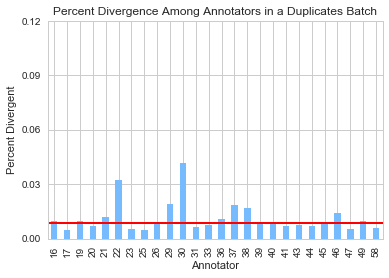

In [419]:
#### just 1 time 

from collections import Counter
#count number of times consensus
cnt = Counter()
for word in list(just1.user_id_y):
     cnt[word] += 1

d={}

for key, value in cnt.items():
    d[key] = value

#count number of times total
cnt = Counter()
for word in list(dfpayloads['user_id']):
     cnt[word] += 1

t={}

for key, value in cnt.items():
    t[key] = value
## merge the two
d = pd.DataFrame.from_dict(d, orient='index').reset_index()
t = pd.DataFrame.from_dict(t, orient='index').reset_index()
final = pd.merge(d,t , on = 'index')
final['%'] = final['0_x']/final['0_y']
final.sort_values(['%'], ascending = False)
final = final.rename(columns={"index": "user_id"})
final["user_id"] = final["user_id"].apply(lambda x: int(x))
final.sort_values(['%']).reset_index()



final.groupby('user_id').sum()['%'].plot(kind='bar', color='xkcd:sky blue')# xlabel="X-axis label", ylabel="y-axix label")
plt.title('Percent Divergence Among Annotators in a Duplicates Batch')
plt.xlabel('Annotator')
plt.grid()
plt.yticks(np.arange(0, .15, step=0.03))
plt.grid()
plt.axhline(final['%'].median(), color='red', linewidth=2)
plt.ylabel('Percent Divergent')
#plt.axhline(countdf['count'].mean(), color='red', linewidth=2)
plt.show()

Text(0.5,1,'Taskus Rate of Divergence on Duplicates')

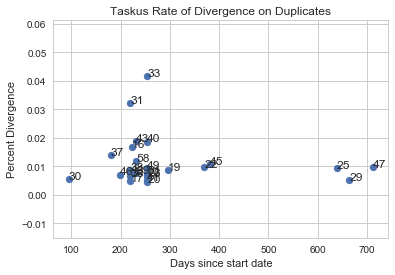

In [401]:
taskusdf = pd.read_csv('/Users/kimia/Downloads/Karen.txt', sep=',')[3:]
#['Id', 'Email', 'First'  ,'Last' ,'Created' ,'Updated', 'Hire Date']
taskusdf = taskusdf[['Unnamed: 0', 'Unnamed: 3','Unnamed: 6' ]]

taskusdf['hire'] = pd.to_datetime(taskusdf['Unnamed: 6'],  errors = 'coerce')

taskusdf['today'] = pd.to_datetime('today')
taskusdf['totaltime'] = taskusdf['today'] -taskusdf['hire']
taskusdf["user_id"] = taskusdf["Unnamed: 0"]
taskusdf["user_id"] = taskusdf["user_id"].apply(lambda x: int(x))
taskusdf['timeclean'] = taskusdf['totaltime'].apply(lambda x: int(str(x)[0:3]))

dft = pd.merge(taskusdf, final, on ='user_id')
dft = dft.sort_values(['%'])

timedf =dft
timedf.head()
y=timedf['%']
z=timedf['timeclean']
n=timedf['user_id']

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Days since start date')
ax.set_ylabel('Percent Divergence')
plt.title('Taskus Rate of Divergence on Duplicates')

Text(0.5,1,'Top Performers on the Duplicates Task')

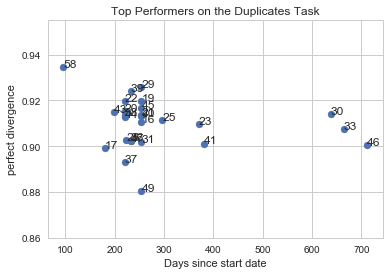

In [381]:
taskusdf = pd.read_csv('/Users/kimia/Downloads/Karen.txt', sep=',')[3:]
#['Id', 'Email', 'First'  ,'Last' ,'Created' ,'Updated', 'Hire Date']
taskusdf = taskusdf[['Unnamed: 0', 'Unnamed: 3','Unnamed: 6' ]]

taskusdf['hire'] = pd.to_datetime(taskusdf['Unnamed: 6'],  errors = 'coerce')

taskusdf['today'] = pd.to_datetime('today')
taskusdf['totaltime'] = taskusdf['today'] -taskusdf['hire']
taskusdf["user_id"] = taskusdf["Unnamed: 0"]
taskusdf["user_id"] = taskusdf["user_id"].apply(lambda x: int(x))
taskusdf['timeclean'] = taskusdf['totaltime'].apply(lambda x: int(str(x)[0:3]))

dft = pd.merge(taskusdf, final, on ='user_id')
dft = dft.sort_values(['%'])
timedf = dft
y=timedf['%']
z=timedf['timeclean']
n=timedf['user_id']

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Days since start date')
ax.set_ylabel('perfect divergence')
plt.title('Top Performers on the Duplicates Task')

In [266]:
dft.sort_values(['%'])

Unnamed: 0  Unnamed: 3  Unnamed: 6       hire      today totaltime  \
7          25          Te  10/20/2017 2017-10-20 2018-07-01  254 days   
1          17      Calibo  11/23/2017 2017-11-23 2018-07-01  220 days   
23         47     Pascual    9/5/2016 2016-09-05 2018-07-01  664 days   
6          23   Dela Rosa  10/20/2017 2017-10-20 2018-07-01  254 days   
25         58       Reyes   3/28/2018 2018-03-28 2018-07-01   95 days   
11         31    Cruspero  10/20/2017 2017-10-20 2018-07-01  254 days   
18         41      Abeabe  11/23/2017 2017-11-23 2018-07-01  220 days   
3          20    Lagumbay  10/20/2017 2017-10-20 2018-07-01  254 days   
20         44       Camet  12/14/2017 2017-12-14 2018-07-01  199 days   
19         43      Glomar  10/20/2017 2017-10-20 2018-07-01  254 days   
12         33       Taala  11/11/2017 2017-11-11 2018-07-01  232 days   
8          26    Prudente  11/23/2017 2017-11-23 2018-07-01  220 days   
16         39  Camantigue    9/8/2017 2017-09-08 2018-07-01  296 days   
21         45    Dangalan  11/23/2017 2017-11-23 2018-07-01  220 days   
17         40       Guieb  10/20/2017 2017-10-20 2018-07-01  254 days   
0          16      Borres   10/1/2016 2016-10-01 2018-07-01  638 days   
2          19     Garciso   7/19/2016 2016-07-19 2018-07-01  712 days   
24         49   Penecilla   6/26/2017 2017-06-26 2018-07-01  370 days   
13         36       Obina   6/15/2017 2017-06-15 2018-07-01  381 days   
4          21   Hernandez  11/11/2017 2017-11-11 2018-07-01  232 days   
22         46    Olivares    1/2/2018 2018-01-02 2018-07-01  180 days   
15         38    Martinez  11/20/2017 2017-11-20 2018-07-01  223 days   
14         37  Sooksingha  10/20/2017 2017-10-20 2018-07-01  254 days   
9          29      Lozano  11/11/2017 2017-11-11 2018-07-01  232 days   
5          22      Ropeta  11/23/2017 2017-11-23 2018-07-01  220 days   
10         30     Remulla  10/20/2017 2017-10-20 2018-07-01  254 days   

    user_id  timeclean  0_x   0_y         %  
7        25        254   33  7368  0.004479  
1        17        220   31  6581  0.004711  
23       47        664   22  4264  0.005159  
6        23        254   43  8133  0.005287  
25       58         95   43  7686  0.005595  
11       31        254   37  5618  0.006586  
18       41        220   40  5952  0.006720  
3        20        254   54  7729  0.006987  
20       44        199   56  7869  0.007117  
19       43        254   42  5559  0.007555  
12       33        232   58  7648  0.007584  
8        26        220   47  5775  0.008139  
16       39        296   65  7582  0.008573  
21       45        220   67  7655  0.008752  
17       40        254   56  6027  0.009292  
0        16        638   65  6866  0.009467  
2        19        712    5   522  0.009579  
24       49        370   67  6862  0.009764  
13       36        381   65  6031  0.010778  
4        21        232   92  7823  0.011760  
22       46        180  108  7671  0.014079  
15       38        223  100  5967  0.016759  
14       37        254  131  7008  0.018693  
9        29        232  143  7571  0.018888  
5        22        220  154  4771  0.032278  
10       30        254  250  5997  0.041688

In [271]:
dfpayloads['starttime'] = (dfpayloads.created_at).apply(lambda x: (pd.to_datetime(str(x))))
dfpayloads['endtime'] = (dfpayloads.updated_at).apply(lambda x: (pd.to_datetime(str(x))))
dfpayloads['totaltime'] = (dfpayloads['endtime'] - dfpayloads['starttime'] )

Text(0.5,1,'The Distribution of Log(Seconds) per Task')

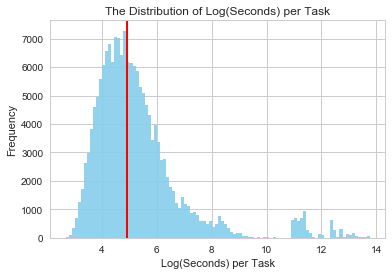

In [370]:
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
dfpayloads['seconds'] = (dfpayloads['totaltime'].sort_values()).dt.total_seconds()[:168500] #.dt.total_seconds())
dfpayloads['logseconds'] = dfpayloads['seconds'].apply(lambda x: np.log(x))
#ax = sns.boxplot(x=dfpayloads['seconds'])
plt.hist(dfpayloads['logseconds'].dropna(),bins=100, alpha=0.9, color='skyblue');
#sns.kdeplot(dfpayloads['seconds'].dropna())
plt.xlabel('Log(Seconds) per Task')
plt.ylabel('Frequency')
plt.axvline(dfpayloads['logseconds'].median(), color='red', linewidth=2)
plt.title('The Distribution of Log(Seconds) per Task')

[Text(0.5,1,'The Distribution of Log(Seconds) per Task')]

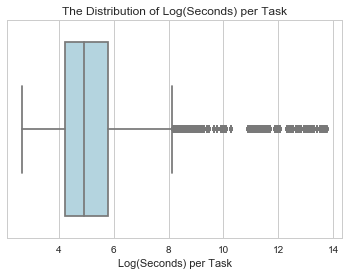

In [369]:
ax = sns.boxplot(x=dfpayloads['logseconds'], color='lightblue')
ax.set(xlabel="Log(Seconds) per Task")
ax.set(title='The Distribution of Log(Seconds) per Task')

In [277]:
          
dfpayloads['seconds'] = dfpayloads['totaltime'].dt.total_seconds()#.groupby([ 'id', ]).sum()['totaltime']#.to_frame().reset_index()

In [281]:
time = dfpayloads.groupby([ 'user_id', ]).sum()['seconds'].to_frame().reset_index()
time['mins'] = time['seconds'].apply(lambda x: x/60)

In [283]:
time['hours'] = time['mins'].apply(lambda x: x/60)

In [311]:
timedf

user_id       seconds          mins         hours  hourrank  index     0  \
0        19  3.056959e+05  5.094931e+03     84.915517      26.0     19   522   
1        43  1.344652e+06  2.241087e+04    373.514517      25.0     43  5559   
2        31  1.054993e+07  1.758321e+05   2930.535666      24.0     31  5618   
3        26  1.324667e+07  2.207779e+05   3679.631508      23.0     26  5775   
4        16  1.430299e+07  2.383831e+05   3973.051764      22.0     16  6866   
5        46  1.890905e+07  3.151509e+05   5252.515046      21.0     46  7671   
6        17  1.917845e+07  3.196409e+05   5327.348337      20.0     17  6581   
7        49  2.240459e+07  3.734098e+05   6223.497025      19.0     49  6862   
8        58  2.251225e+07  3.752041e+05   6253.402020      18.0     58  7686   
9        33  2.398222e+07  3.997037e+05   6661.728519      17.0     33  7648   
10       41  2.542793e+07  4.237988e+05   7063.312806      16.0     41  5952   
11       37  2.645816e+07  4.409693e+05   7349.488899      15.0     37  7008   
12       23  2.868653e+07  4.781088e+05   7968.479908      14.0     23  8133   
13       22  3.390381e+07  5.650634e+05   9417.723643      13.0     22  4771   
14       44  3.625809e+07  6.043014e+05  10071.690539      12.0     44  7869   
15       40  4.127641e+07  6.879402e+05  11465.670169      11.0     40  6027   
16       39  4.371464e+07  7.285773e+05  12142.955081      10.0     39  7582   
17       45  4.418445e+07  7.364076e+05  12273.459462       9.0     45  7655   
18       29  4.668599e+07  7.780999e+05  12968.331008       8.0     29  7571   
19       20  4.798947e+07  7.998245e+05  13330.408103       7.0     20  7729   
20       30  6.013889e+07  1.002315e+06  16705.246367       6.0     30  5997   
21       21  7.674989e+07  1.279165e+06  21319.415084       5.0     21  7823   
22       25  8.600779e+07  1.433463e+06  23891.051434       4.0     25  7368   
23       47  9.547736e+07  1.591289e+06  26521.489513       3.0     47  4264   
24       38  1.033267e+08  1.722112e+06  28701.869651       2.0     38  5967   
25       36  1.788177e+08  2.980295e+06  49671.583264       1.0     36  6031   

    timeper?   0_x   0_y         %  
0   0.162673   470   522  0.900383  
1   0.067191  5095  5559  0.916532  
2   0.521633  5131  5618  0.913314  
3   0.637166  5275  5775  0.913420  
4   0.578656  6276  6866  0.914069  
5   0.684724  6897  7671  0.899101  
6   0.809504  6053  6581  0.919769  
7   0.906951  6242  6862  0.909647  
8   0.813609  7183  7686  0.934556  
9   0.871042  7068  7648  0.924163  
10  1.186713  5433  5952  0.912802  
11  1.048728  6321  7008  0.901969  
12  0.979771  7531  8133  0.925981  
13  1.973952  4260  4771  0.892895  
14  1.279920  7201  7869  0.915110  
15  1.902384  5488  6027  0.910569  
16  1.601550  6909  7582  0.911237  
17  1.603326  7008  7655  0.915480  
18  1.712895  6830  7571  0.902127  
19  1.724726  7108  7729  0.919653  
20  2.785601  5280  5997  0.880440  
21  2.725222  7060  7823  0.902467  
22  3.242542  6731  7368  0.913545  
23  6.219862  3869  4264  0.907364  
24  4.810100  5386  5967  0.902631  
25  8.236044  5435  6031  0.901177

Text(0.5,1,'Time Spent on Duplicates by Performance')

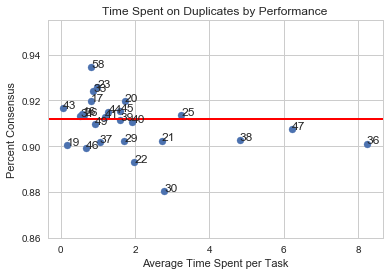

In [424]:
t['user_id'] = t['index']
timedf = pd.merge(time, t , on = 'user_id')
timedf['timeper?'] = timedf['hours']/timedf[0]

timedf = pd.merge(timedf, final, on ='user_id')
y=timedf['%']
z=timedf['timeper?']
n=timedf['user_id']

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))

    
ax.set_xlabel('Average Time Spent per Task')
ax.set_ylabel('Percent Consensus')
plt.axhline(timedf['%'].median(), color='red', linewidth=2)
plt.title('Time Spent on Duplicates by Performance')

Text(0.5,1,'Time Spent on Duplicates by Performance')

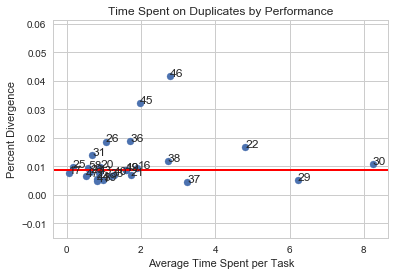

In [421]:
t['user_id'] = t['index']
timedf = pd.merge(time, t , on = 'user_id')
timedf['timeper?'] = timedf['hours']/timedf[0]

timedf = pd.merge(timedf, final, on ='user_id')
timedf = timedf.sort_values(['%'])
y=timedf['%']
z=timedf['timeper?']
n=timedf['user_id']

fig, ax = plt.subplots()
ax.scatter(z, y)
#ax = fig.add_subplot(111, axisbg='white')
for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Average Time Spent per Task')
ax.set_ylabel('Percent Divergence')
plt.axhline(timedf['%'].median(), color='red', linewidth=2)
plt.title('Time Spent on Duplicates by Performance')

Text(0.5,1,'Time Spent on Duplicates by Performance')

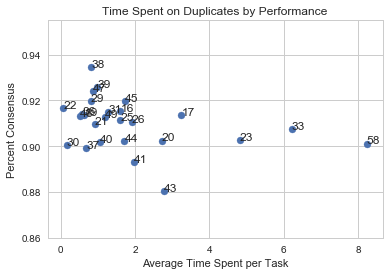

In [417]:
t['user_id'] = t['index']
timedf = pd.merge(time, t , on = 'user_id')
timedf['timeper?'] = timedf['hours']/timedf[0]

timedf = pd.merge(timedf, final, on ='user_id')
timedf = timedf.sort_values(['%'])
y=timedf['%']
z=timedf['timeper?']
n=timedf['user_id']

fig, ax = plt.subplots()
ax.scatter(z, y)
#ax = fig.add_subplot(111, axisbg='white')
for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Average Time Spent per Task')
ax.set_ylabel('Percent Consensus')

plt.title('Time Spent on Duplicates by Performance')

In [303]:
timedf

user_id       seconds          mins         hours  hourrank  index     0  \
0        19  3.056959e+05  5.094931e+03     84.915517      26.0     19   522   
1        43  1.344652e+06  2.241087e+04    373.514517      25.0     43  5559   
2        31  1.054993e+07  1.758321e+05   2930.535666      24.0     31  5618   
3        26  1.324667e+07  2.207779e+05   3679.631508      23.0     26  5775   
4        16  1.430299e+07  2.383831e+05   3973.051764      22.0     16  6866   
5        46  1.890905e+07  3.151509e+05   5252.515046      21.0     46  7671   
6        17  1.917845e+07  3.196409e+05   5327.348337      20.0     17  6581   
7        49  2.240459e+07  3.734098e+05   6223.497025      19.0     49  6862   
8        58  2.251225e+07  3.752041e+05   6253.402020      18.0     58  7686   
9        33  2.398222e+07  3.997037e+05   6661.728519      17.0     33  7648   
10       41  2.542793e+07  4.237988e+05   7063.312806      16.0     41  5952   
11       37  2.645816e+07  4.409693e+05   7349.488899      15.0     37  7008   
12       23  2.868653e+07  4.781088e+05   7968.479908      14.0     23  8133   
13       22  3.390381e+07  5.650634e+05   9417.723643      13.0     22  4771   
14       44  3.625809e+07  6.043014e+05  10071.690539      12.0     44  7869   
15       40  4.127641e+07  6.879402e+05  11465.670169      11.0     40  6027   
16       39  4.371464e+07  7.285773e+05  12142.955081      10.0     39  7582   
17       45  4.418445e+07  7.364076e+05  12273.459462       9.0     45  7655   
18       29  4.668599e+07  7.780999e+05  12968.331008       8.0     29  7571   
19       20  4.798947e+07  7.998245e+05  13330.408103       7.0     20  7729   
20       30  6.013889e+07  1.002315e+06  16705.246367       6.0     30  5997   
21       21  7.674989e+07  1.279165e+06  21319.415084       5.0     21  7823   
22       25  8.600779e+07  1.433463e+06  23891.051434       4.0     25  7368   
23       47  9.547736e+07  1.591289e+06  26521.489513       3.0     47  4264   
24       38  1.033267e+08  1.722112e+06  28701.869651       2.0     38  5967   
25       36  1.788177e+08  2.980295e+06  49671.583264       1.0     36  6031   

    timeper?  0_x   0_y         %  
0   0.162673    5   522  0.009579  
1   0.067191   42  5559  0.007555  
2   0.521633   37  5618  0.006586  
3   0.637166   47  5775  0.008139  
4   0.578656   65  6866  0.009467  
5   0.684724  108  7671  0.014079  
6   0.809504   31  6581  0.004711  
7   0.906951   67  6862  0.009764  
8   0.813609   43  7686  0.005595  
9   0.871042   58  7648  0.007584  
10  1.186713   40  5952  0.006720  
11  1.048728  131  7008  0.018693  
12  0.979771   43  8133  0.005287  
13  1.973952  154  4771  0.032278  
14  1.279920   56  7869  0.007117  
15  1.902384   56  6027  0.009292  
16  1.601550   65  7582  0.008573  
17  1.603326   67  7655  0.008752  
18  1.712895  143  7571  0.018888  
19  1.724726   54  7729  0.006987  
20  2.785601  250  5997  0.041688  
21  2.725222   92  7823  0.011760  
22  3.242542   33  7368  0.004479  
23  6.219862   22  4264  0.005159  
24  4.810100  100  5967  0.016759  
25  8.236044   65  6031  0.010778

In [315]:
(dfpayloads[dfpayloads.user_id ==36])['totaltime'].max()

Timedelta('6 days 20:32:38.238000')

In [ ]:
(dfpayloads[dfpayloads.user_id ==36])['totaltime'].min()  == Timedelta('0 days 00:00:14.564000')

In [425]:
# how often using unsure? 

unsuredf= dfpayloads[dfpayloads.annotation == 'unsure'][['user_id', 'annotation']]


from collections import Counter
#count number of times consensus
cnt = Counter()
for word in list(unsuredf.user_id):
     cnt[word] += 1

d={}

for key, value in cnt.items():
    d[key] = value

#count number of times total
cnt = Counter()
for word in list(dfpayloads['user_id']):
     cnt[word] += 1

t={}

for key, value in cnt.items():
    t[key] = value
## merge the two
d = pd.DataFrame.from_dict(d, orient='index').reset_index()
t = pd.DataFrame.from_dict(t, orient='index').reset_index()
final = pd.merge(d,t , on = 'index')
final['user_id'] = final['index']
final['%unsure'] = final['0_x']/final['0_y']
final.sort_values(['%unsure']).reset_index()
final['%unsure'].median()

0.002690885124343451